# Practice 7 by Vladyslav Bezborodov

## Part1

### Порівняння архітектур детекторів: YOLOv8, RT-DETR, Mask R-CNN

| Модель        | Кількість параметрів            | Середній час обробки (GPU) | Особливості архітектури |
|---------------|----------------------------------|-----------------------------|--------------------------|
| **YOLOv8**     | ~11M (YOLOv8n) – ~68M (YOLOv8x) | ~5–10 мс                    | Одноетапна, базується на CNN, швидка, проста, без anchor-ів |
| **RT-DETR**    | ~44M–98M                        | ~25–50 мс                   | Також одноетапна, але трансформерна, без NMS, сучасна й легка у використанні |
| **Mask R-CNN** | ~44M–145M                       | ~80–120 мс                  | Двоетапна, з anchor-ами, дуже точна, але працює повільніше |

Серед трьох розглянутих архітектур YOLOv8 є найшвидшою, що робить її зручною для задач у реальному часі, хоча вона може втрачати точність у складніших сценах. RT-DETR виступає як компроміс між швидкістю та точністю — вона базується на сучасній трансформерній архітектурі, працює без NMS і має просту структуру. Mask R-CNN демонструє найвищу точність, проте через свою повільну роботу не підходить для застосування в реальному часі


## Part2

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split

import random
import time
from tqdm import tqdm


import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.model_selection import ParameterGrid

import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

%matplotlib inline

In [28]:
data_dir = "../Datasets/bottle_images/"

In [27]:
# os.getcwd()
# os.listdir()
# os.listdir(os.path.join(os.getcwd(), 'detectron2'))

In [12]:
import sys, os, distutils.core

# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
#!git clone 'https://github.com/facebookresearch/detectron2'
# Get absolute path to setup.py

In [13]:
import os
setup_path = os.path.abspath(os.path.join(os.getcwd(), 'detectron2', 'setup.py'))
print("Looking for setup.py at:", setup_path)
print("Exists:", os.path.exists(setup_path))


Looking for setup.py at: C:\Users\Cyberpower\PycharmProjects\modelTraining\DL4CV\2025\Practices\detectron2\setup.py
Exists: True


In [18]:
dist = distutils.core.run_setup(setup_path)
dist.install_requires

['Pillow>=7.1',
 'matplotlib',
 'pycocotools>=2.0.2',
 'termcolor>=1.1',
 'yacs>=0.1.8',
 'tabulate',
 'cloudpickle',
 'tqdm>4.29.0',
 'tensorboard',
 'fvcore<0.1.6,>=0.1.5',
 'iopath<0.1.10,>=0.1.7',
 'omegaconf<2.4,>=2.1',
 'hydra-core>=1.1',
 'black',
 'packaging']

In [20]:
# Install required packages
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
import subprocess

# install all dependencies from dist.install_requires
subprocess.run(
    ["python", "-m", "pip", "install", *dist.install_requires],
    check=True
)


CompletedProcess(args=['python', '-m', 'pip', 'install', 'Pillow>=7.1', 'matplotlib', 'pycocotools>=2.0.2', 'termcolor>=1.1', 'yacs>=0.1.8', 'tabulate', 'cloudpickle', 'tqdm>4.29.0', 'tensorboard', 'fvcore<0.1.6,>=0.1.5', 'iopath<0.1.10,>=0.1.7', 'omegaconf<2.4,>=2.1', 'hydra-core>=1.1', 'black', 'packaging'], returncode=0)

In [ ]:
# Add local detectron2 path to sys.path for importing
sys.path.insert(0, os.path.abspath('./detectron2'))

In [22]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2 as cv

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Custom bottle images  

from different angle and with different level of luminosity

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='C:\\Users\\Cyberpower\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Users\\Cyberpower\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Users\\Cyberpower\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(

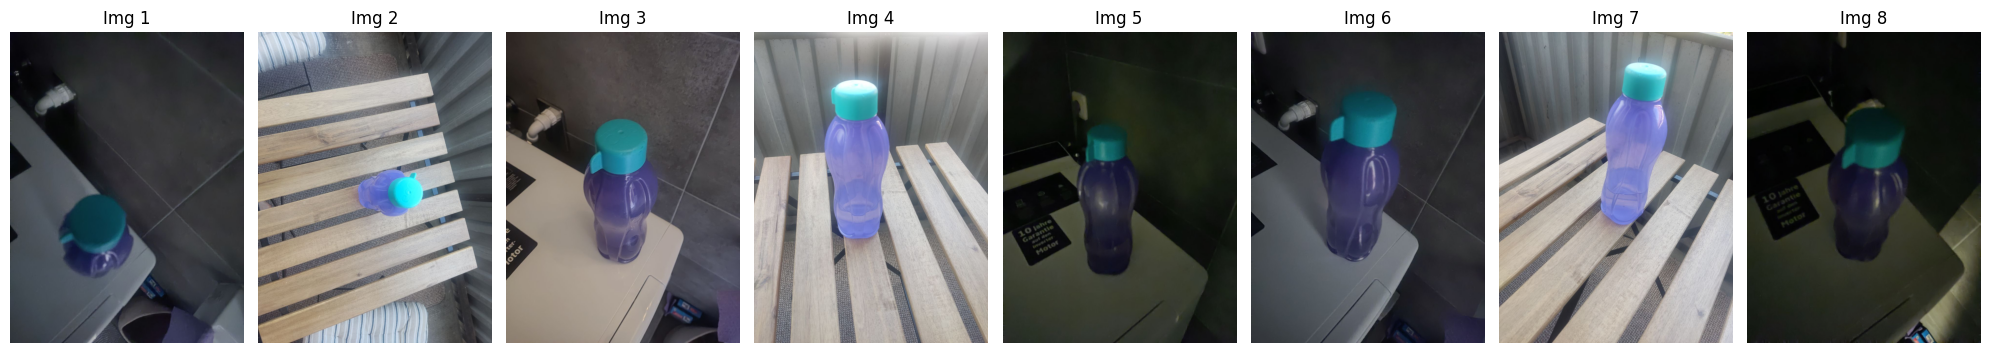

In [30]:
image_filenames = [
    'bottle_top_medium_light.jpg',
    'bottle_top_good_light.jpg',
    'bottle_front_medium_light.jpg',
    'bottle_front_good_light.jpg',
    'bottle_front_bad_light.jpg',
    'bottle_from_a_side_medium_light.jpg',
    'bottle_from_a_side_good_light.jpg',
    'bottle_from_a_side_bad_light.jpg'
]

images = [cv2.cvtColor(cv2.imread(os.path.join(data_dir, fname)), cv2.COLOR_BGR2RGB)
          for fname in image_filenames]

plt.figure(figsize=(20, 4))

for i, img in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Img {i+1}')

plt.tight_layout()
plt.show()


In [32]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[04/09 16:47:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[Checkpointer] Loading from C:\Users\Cyberpower/.torch/iopath_cache\detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600\model_final_f10217.pkl ...
Reading a file from 'Detectron2 Model Zoo'


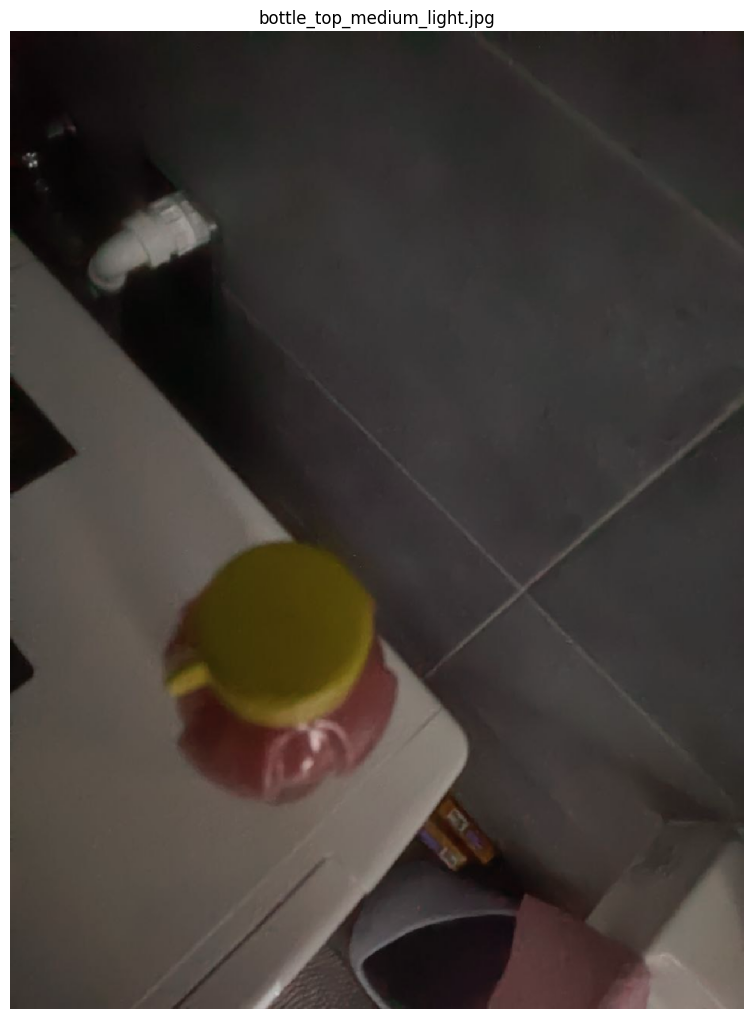

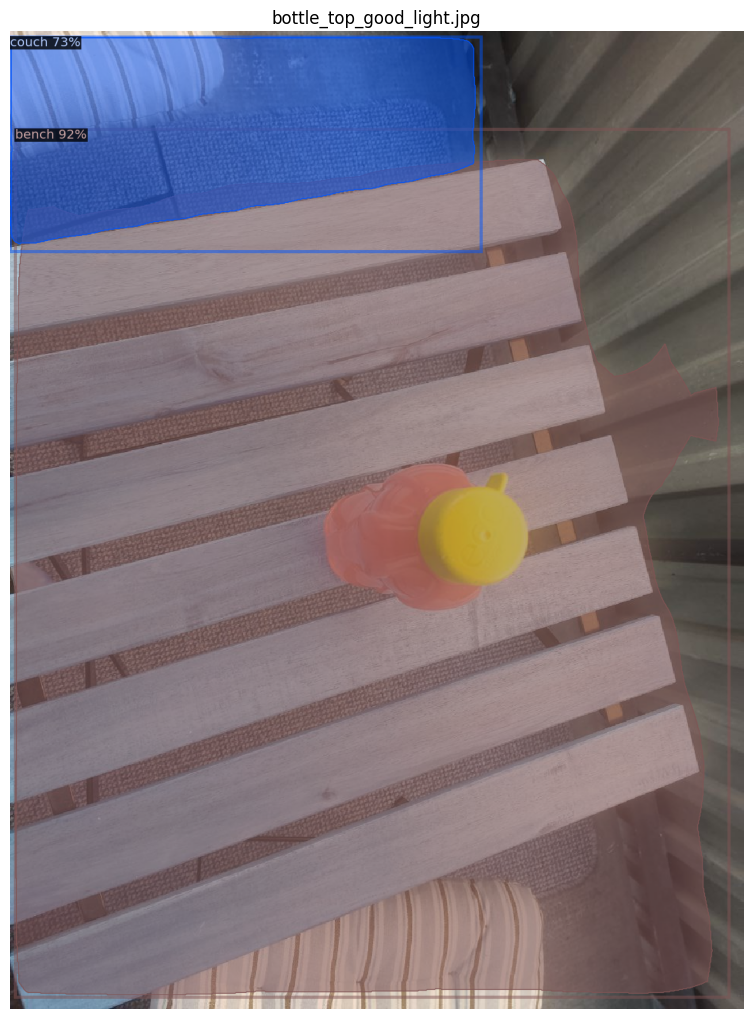

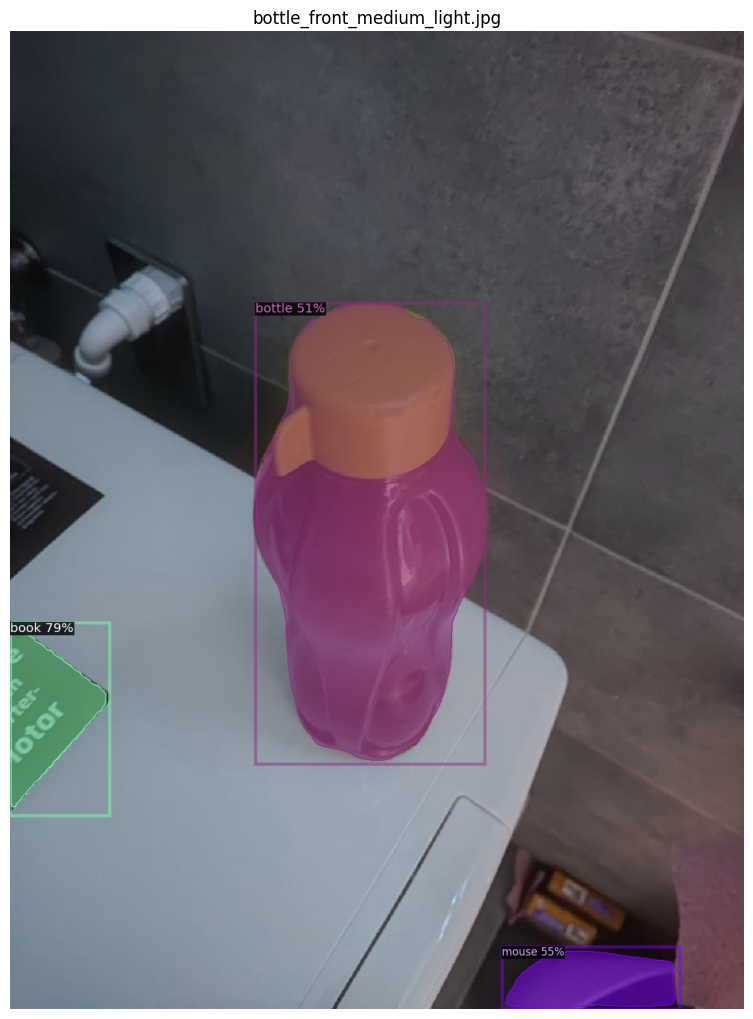

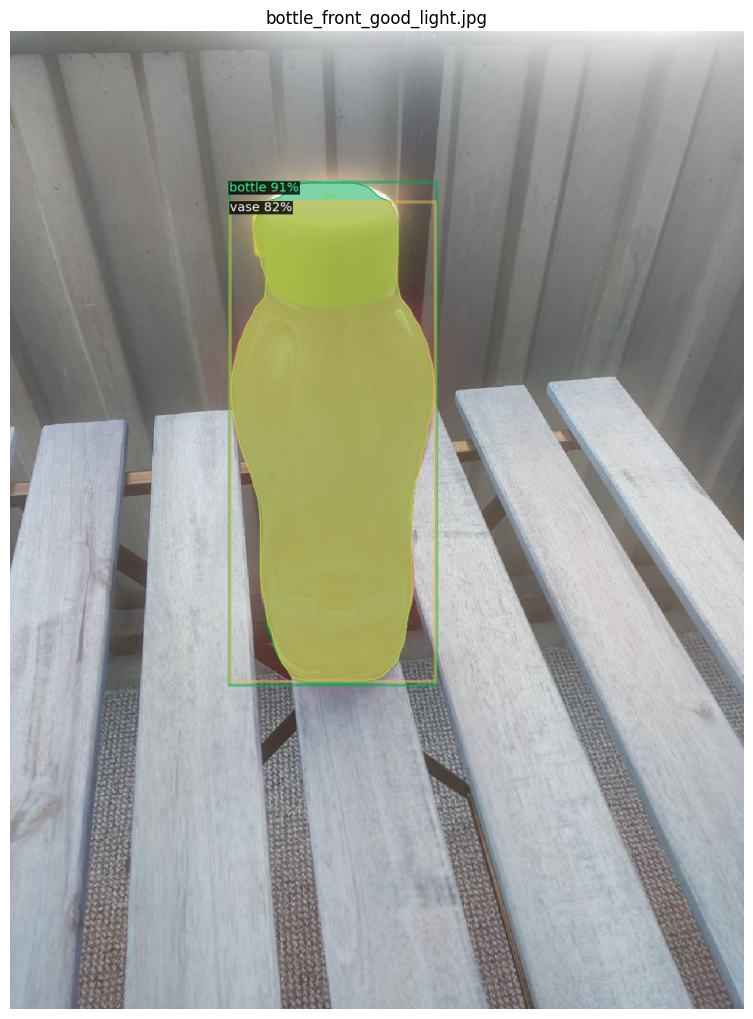

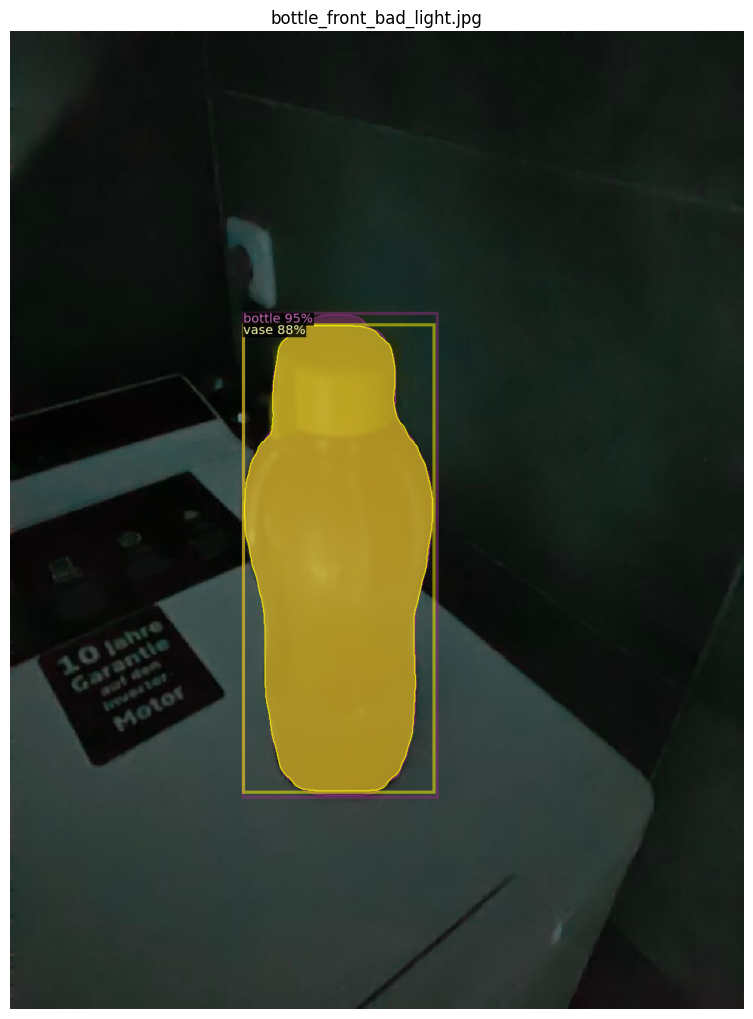

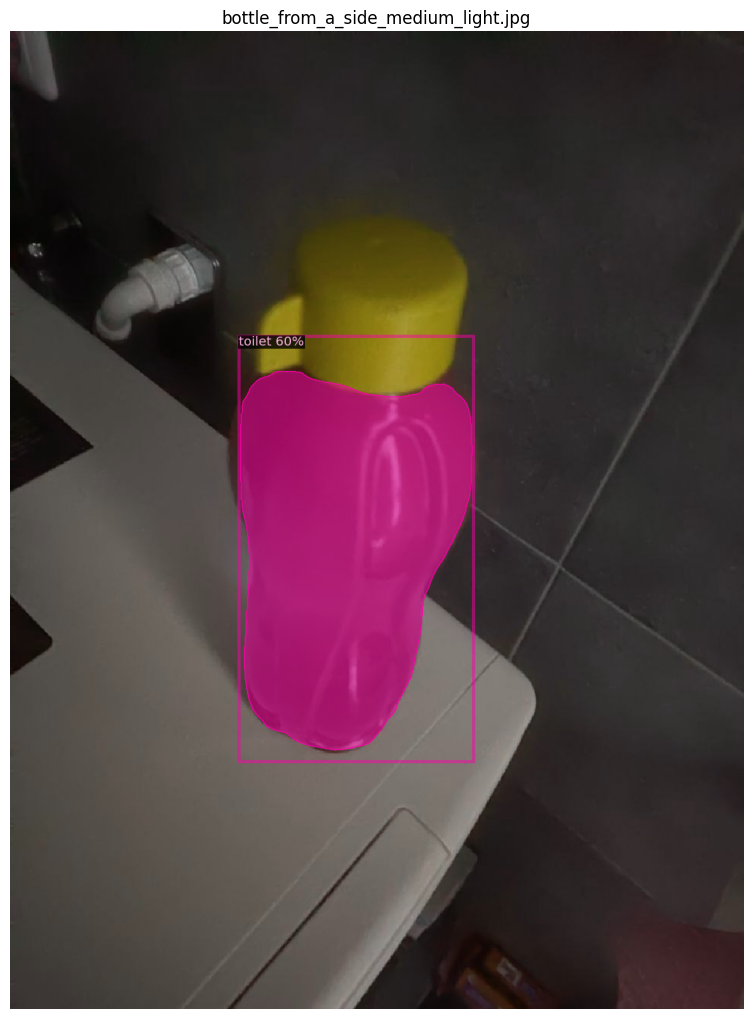

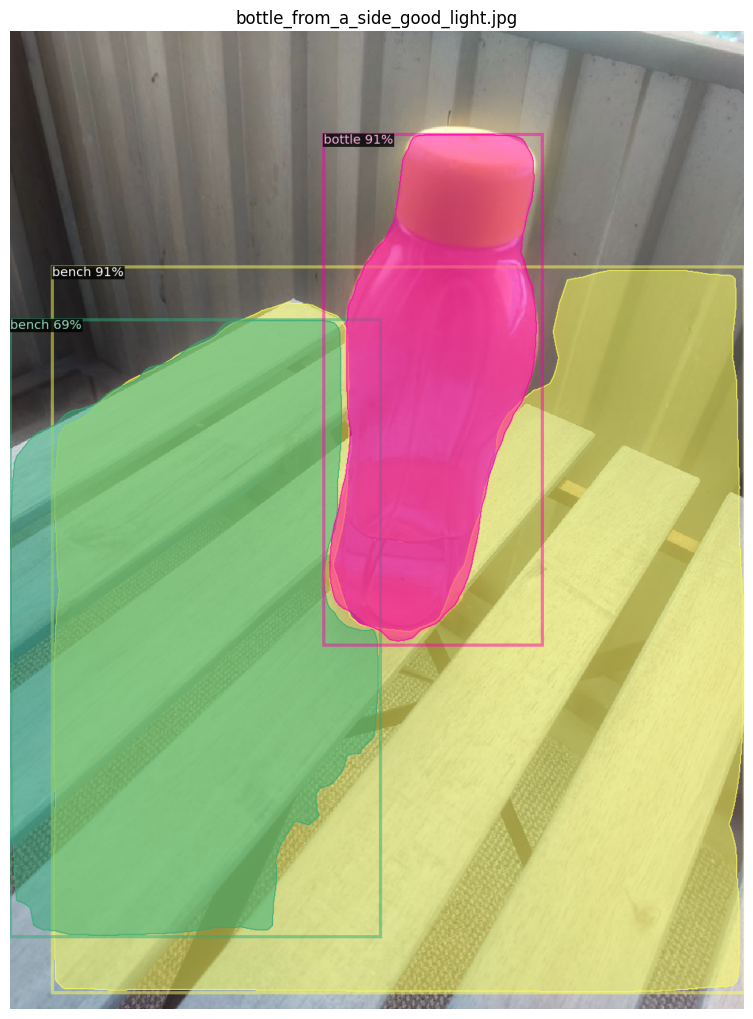

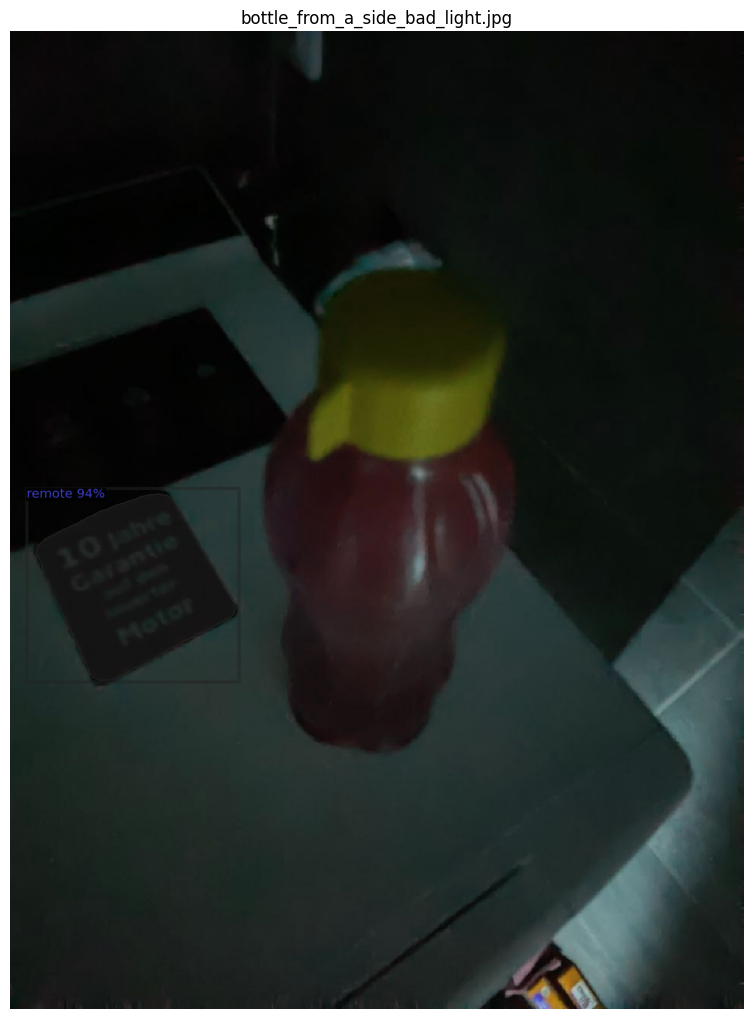

In [45]:
import matplotlib.pyplot as plt

outputs = []

for img_name in image_filenames:
    im = cv2.imread(os.path.join(data_dir, img_name))
    img_output = predictor(im)

    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(img_output["instances"].to("cpu"))

    plt.figure(figsize=(10, 10))  # Збільшений розмір зображення
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title(img_name)
    plt.axis('off')  # Прибрати осі та текст
    plt.tight_layout(pad=0)  # Без відступів
    plt.show()

    outputs.append(img_output)


In [50]:
idx=0
for output in outputs:
    print(image_filenames[idx],'\n')
    print(output["instances"].pred_classes)
    print(output["instances"].pred_boxes, '\n')
    idx+=1

bottle_top_medium_light.jpg 

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4))) 

bottle_top_good_light.jpg 

tensor([13, 57], device='cuda:0')
Boxes(tensor([[   6.9063,  128.5253,  940.2507, 1264.3948],
        [   0.0000,    7.3607,  615.5905,  288.4913]], device='cuda:0')) 

bottle_front_medium_light.jpg 

tensor([73, 64, 39], device='cuda:0')
Boxes(tensor([[4.0621e-01, 7.7412e+02, 1.2981e+02, 1.0264e+03],
        [6.4372e+02, 1.1981e+03, 8.7559e+02, 1.2798e+03],
        [3.2105e+02, 3.5591e+02, 6.2106e+02, 9.5935e+02]], device='cuda:0')) 

bottle_front_good_light.jpg 

tensor([39, 75], device='cuda:0')
Boxes(tensor([[287.0424, 197.4364, 557.4046, 856.1642],
        [287.5844, 223.4859, 556.1984, 850.5997]], device='cuda:0')) 

bottle_front_bad_light.jpg 

tensor([39, 75], device='cuda:0')
Boxes(tensor([[ 305.3889,  368.8864,  557.9521, 1002.1719],
        [ 305.3928,  384.0938,  554.3232,  995.4286]], device='cuda:0')) 

bottle_from_a_si

## Summary table

| Файл                           | Пляшка виявлена? | Маска? | Confidence | Коментар                                |
|--------------------------------|------------------|--------|------------|-----------------------------------------|
| bottle_top_medium_light        | ❌               | —      | —          | Занадто незвичний ракурс                |
| bottle_top_good_light          | ✅               | ❌     | —          | Виявлена, але маска не накладена        |
| bottle_front_medium_light      | ✅               | ✅     | ~51%       | Слабке освітлення вплинуло              |
| bottle_front_good_light        | ✅               | ✅     | 91%        | Найкращий кейс                          |
| bottle_front_bad_light         | ✅               | ✅     | 95%        | Дуже добре, але плутанина з "vase"      |
| bottle_from_a_side_medium_light| ❌               | —      | —          | Помилкова класифікація                  |
| bottle_from_a_side_good_light  | ✅               | ✅     | 91%        | Добре, завдяки світлу                   |
| bottle_from_a_side_bad_light   | ❌               | —      | —          | Повністю не вдалося через освітлення    |


## Conclusions

Detectron2 had trouble detecting the bottle when it was seen from unusual angles, like from the top or the side. This shows that the model is quite sensitive to how the object is positioned. Lighting also made a difference, but it was still able to detect the bottle from the front even when the lighting was bad. This means the model depends more on the shape and position of the bottle than on how bright the image is.